In [183]:
from math import radians, sin, cos, acos

slon, slat = radians(2.3522219), radians(48.856614)
elon, elat = radians(2.570289), radians(48.354976)

dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
print("The distance is %.2fkm." % dist)

def compute_earth_dist(Xo, Xa, Yo, Ya):
    [Xo, Xa, Yo, Ya] = [utils.radians(_) for _ in [Xo, Xa, Yo, Ya]]

The distance is 58.04km.


In [188]:
import torch
import numpy as np
import utils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

import renyi
import utils
import sxp

In [185]:
df = pd.read_csv("./data/france/pop_fr_geoloc_1975_2010.csv")

In [204]:
X = np.array([df.long.values, df.lat.values]).T
%time kmeans = MiniBatchKMeans(n_clusters=97, random_state=0).fit(X)
pp = np.zeros((len(X), kmeans.n_clusters))
pp[range(len(X)), kmeans.labels_] = 1
pops = df.pop_1975.values[:, None] / df.pop_1975.values.sum()
aa = (pp * pops).sum(0)

Wall time: 780 ms


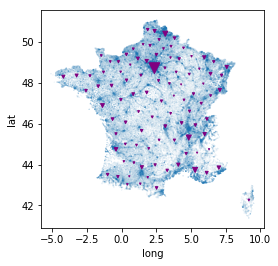

In [205]:
fig, ax = plt.subplots(figsize=(4, 4))
df.plot(ax=ax, kind="scatter", x="long", y="lat", alpha=0.7, s=df.pop_2010 / (10**5));
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='v', c='purple', s=700*aa)

torch.Size([1, 36318])

In [374]:
alpha, d = 1, 2

batch_size = 100
bprob = torch.tensor(np.array(batch_size*[1/batch_size])[None, :])

tX = torch.tensor([X[:, 0] / 10,  X[:, 1] / 50]).transpose(0, 1)
mu = torch.tensor(df.pop_1975.values[None, :] / df.pop_1975.values.sum())
cat1 = torch.distributions.Categorical(probs=mu)

n = 97
nu = torch.tensor(np.array(n*[1/n])[None, :])

rix = np.random.choice(len(tX), n)
Y = torch.nn.Parameter(tX[rix].clone())
#Y = torch.nn.Parameter(torch.tensor(np.random.multivariate_normal(np.zeros(d), 1.1*np.eye(d), n)))

y_optimizer = torch.optim.Adam([Y], lr=0.01, amsgrad=True)
optims = [y_optimizer]

kernel = lambda x, y: renyi.generic_kernel(x, y, renyi.rbf_kernel)

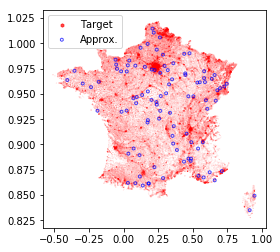

In [375]:
plt.figure(figsize=(4, 4))
plt.scatter(tX.data.numpy()[:, 0], tX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

In [376]:
for _ in range(50):
    
    [_.zero_grad() for _ in optims]
    
    rix = cat1.sample(sample_shape=[batch_size]).squeeze()
    cX = tX[rix]
    loss, K = renyi.mixture_divergence(bprob, cX, nu, Y, alpha, kernel)

    if _ % 10 == 0:
        print("%d - %.4f" % (_, loss.item()))
            
    loss.backward()
    [_.step() for _ in optims]

0 - -0.0034
10 - -0.0279


KeyboardInterrupt: 

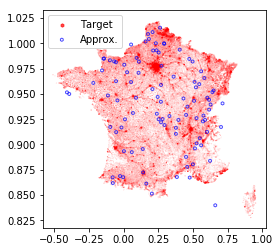

In [371]:
plt.figure(figsize=(4, 4))
plt.scatter(tX.data.numpy()[:, 0], tX.data.numpy()[:, 1], s=list(500*mu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

In [356]:
rix = cat1.sample(sample_shape=[batch_size]).squeeze()

%time loss, K = renyi.mixture_divergence(bprob, tX[rix], nu, Y, alpha, kernel)
loss.item()

Wall time: 1.98 ms


0.0009874580668249987

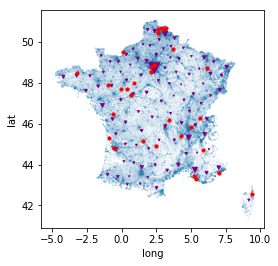

In [297]:
fig, ax = plt.subplots(figsize=(4, 4))
df.plot(ax=ax, kind="scatter", x="long", y="lat", alpha=0.7, s=df.pop_2010 / (10**5));
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='v', c='purple', s=700*aa)
plt.scatter(sampleX[:, 0], sampleX[:, 1], s=10, c='r')

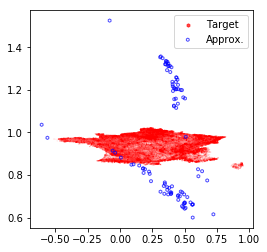